In [1]:
import rasterio
import numpy as np
from rasterio import Affine, features
import geopandas as gpd
from shapely.geometry import mapping, shape, Polygon, MultiPolygon
from rasterio.features import shapes
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon, Rectangle
from shapely.ops import unary_union
from math import floor, ceil, sqrt
from shapely.affinity import affine_transform
from skimage.measure import find_contours
from rasterio.transform import array_bounds
import shapely.wkt

%matplotlib inline


In [2]:
# Create structres and vendor names

structures = [Polygon([(-118.11755479999999352, 33.88250140000000243), (-118.11755440000000306, 33.88243099999999686), (-118.11752260000000092, 33.88243109999999803), (-118.11752250000000686, 33.88239380000000267), (-118.11755399999999838, 33.8823937000000015), (-118.11755399999999838, 33.88237469999999973), (-118.11774060000000475, 33.88237409999999983), (-118.11774119999999755, 33.88250080000000253), (-118.11755479999999352, 33.88250140000000243)]),
          Polygon([(-118.11772545899999898, 33.88249110600000336), (-118.11753415100000097, 33.88249256400010267), (-118.11753279799999916, 33.88236887600000102), (-118.1177241040000041, 33.88236741900009719), (-118.11772545899999898, 33.88249110600000336)]),
          Polygon([(-118.11773590743500506, 33.88238114719789706), (-118.11773858964400574, 33.88250695714410199), (-118.1175487765549974, 33.88250807870539916), (-118.11754818141599799, 33.88243800561979668), (-118.11752612456699296, 33.88243813592919906), (-118.11752581191700529, 33.88240132244899883), (-118.11754802755800142, 33.88240119120160188), (-118.1175478573219948, 33.88238114719050031), (-118.11773590743500506, 33.88238114719789706)])]

struct_names = ['Overture', 'FEMA', 'Vexcel']
weight = [3, 1, 0.5]

In [3]:
# Save to gdf
gdf = gpd.GeoDataFrame({'name': struct_names, 'weight': weight, 'geometry': structures}, crs='EPSG:4326')

#Save to csv
#gdf.to_csv('structures.csv',index=False, header=False)

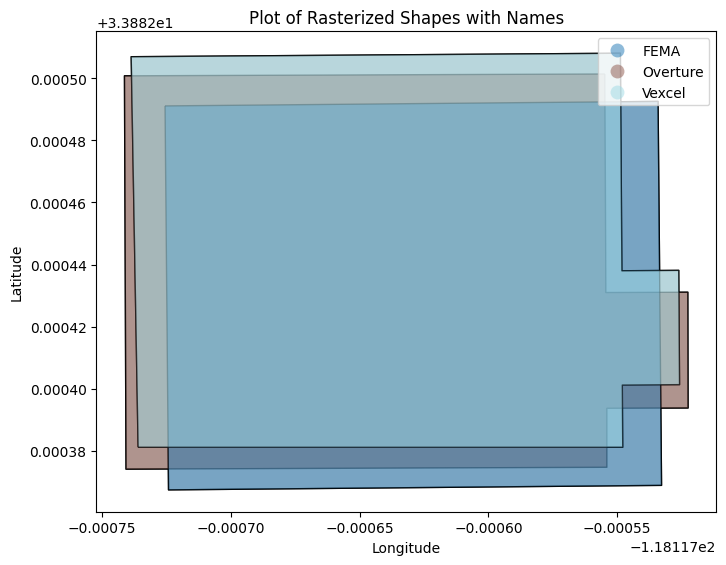

In [82]:
# Plot gdf in one window stacked to view difference in shapes

gdf = gpd.GeoDataFrame({'name': struct_names, 'geometry': structures}, crs='EPSG:4326')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(ax=ax, edgecolor='black', facecolor='lightgray')

# Plot the GeoDataFrame with unique colors and transparency
gdf.plot(ax=ax, column='name', cmap='tab20', edgecolor='black', alpha=0.5, legend=True)


# # Add labels for each shape
# for idx, row in gdf.iterrows():
#     centroid = row.geometry.centroid
#     ax.text(centroid.x, centroid.y, row['name'], fontsize=10, ha='center', va='center',
#             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5))
    
# Customize plot
plt.title("Plot of Rasterized Shapes with Names")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()



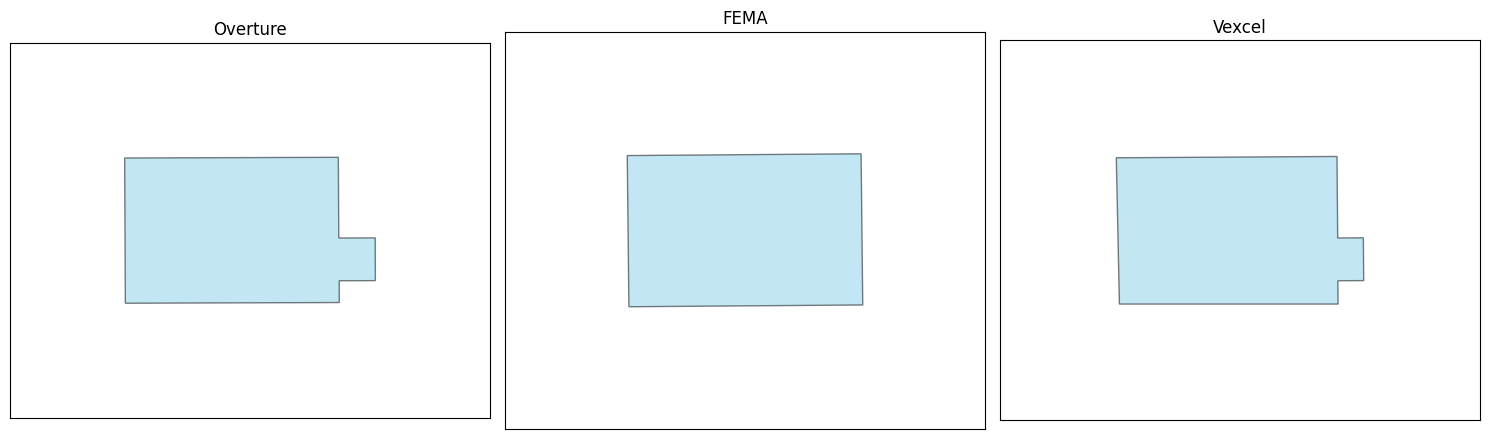

In [83]:
# Plot each polygon in its own subplot
fig, axes = plt.subplots(1, len(structures), figsize=(15, 5))

for i, (shape, name) in enumerate(zip(structures, gdf['name'])):
    ax = axes[i]
    poly_patch = MplPolygon(list(shape.exterior.coords), edgecolor='black', facecolor='skyblue', alpha=0.5)
    ax.add_patch(poly_patch)

    # Set axis limits based on polygon bounds
    min_x, min_y, max_x, max_y = shape.bounds
    ax.set_xlim(min_x - 0.0001, max_x + 0.0001)
    ax.set_ylim(min_y - 0.0001, max_y + 0.0001)

    # Set the title using the 'name' attribute from the GeoDataFrame
    ax.set_title(f"{name}")  # Replace with whatever attribute you want to display
    # Remove x and y axis labels (ticks and labels)
    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([])  # Remove y-axis ticks
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

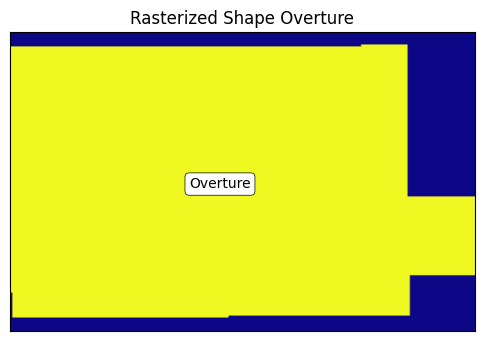

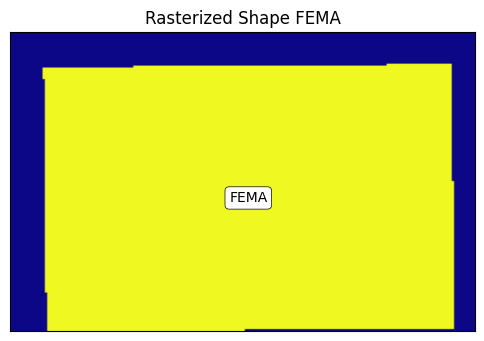

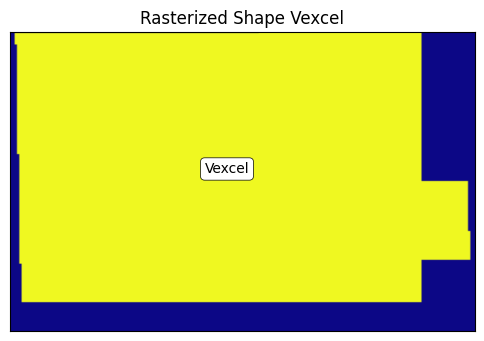

In [95]:
# Loop through each shape and rasterize individually in EPSG 4326 (WGS 84) with 1-meter resolution

# Compute bounding box
xmin, ymin, xmax, ymax = (
    min(p.bounds[0] for p in structures), min(p.bounds[1] for p in structures),
    max(p.bounds[2] for p in structures), max(p.bounds[3] for p in structures)
)

# Define degree-per-meter resolution at 33.88° latitude
lat_res = 0.0000009      # ~1 meter per pixel in latitude
lon_res = 0.00000109     # ~1 meter per pixel in longitude at 33.88° latitude

# Calculate raster dimensions
nx = int((xmax - xmin) / lon_res)
ny = int((ymax - ymin) / lat_res)

# Create affine transform for WGS 84 (still degrees, but 1-meter equivalent)
transform = Affine.translation(xmin, ymax) * Affine.scale(lon_res, -lat_res)

for i, (shape, name) in enumerate(zip(structures, gdf['name'])):
    # Create an empty raster for the current shape
    pa = np.zeros((ny, nx), dtype=np.uint8)
    
    # Rasterize only the current shape
    r = features.rasterize(
        [(mapping(shape), 1)],  # Assign pixel value 1 to this shape
        out_shape=(ny, nx),
        transform=transform
    )
    
    # Store rasterized shape in the raster array
    pa[r > 0] = 1  # Set rasterized pixels to 1 for visualization
    
    # Plot the raster for the current shape
    plt.figure(figsize=(6, 6))

    # Plot the rasterized shape
    plt.imshow(pa, cmap='plasma', origin='upper', extent=[xmin, xmax, ymin, ymax])
    
    # Add the label at the centroid
    centroid = shape.centroid
    plt.text(centroid.x, centroid.y, f"{name}", fontsize=10, ha='center', va='center',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5))
    
    
    plt.title(f"Rasterized Shape {name}")
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

    plt.show()

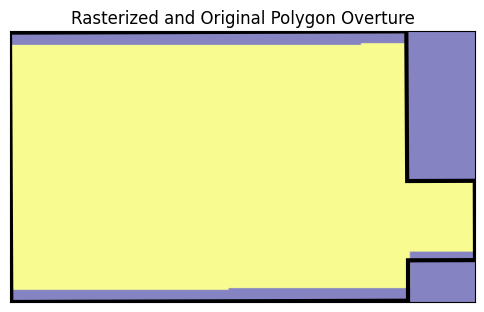

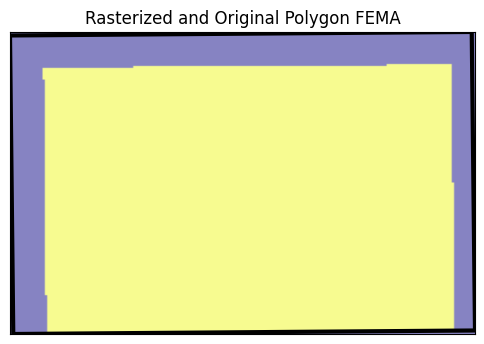

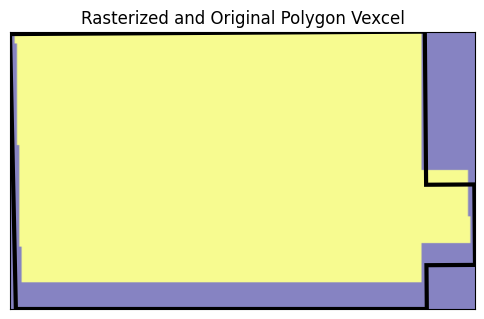

In [ ]:
# Now, let's plot each shape individually with its rasterized version, still 1-meter resolution in EPSG:4326

# Loop through each shape and plot them individually
for i, (shape, name) in enumerate(zip(structures, gdf['name'])):
    # Create an empty raster for the current shape
    pa = np.zeros((ny, nx), dtype=np.uint8)
    
    # Rasterize only the current shape
    r = features.rasterize(
        [(mapping(shape), 1)],  # Assign pixel value 1 to this shape
        out_shape=(ny, nx),
        transform=transform
    )
    
    # Store rasterized shape in the raster array
    pa[r > 0] = 1  # Set rasterized pixels to 1 for visualization
    # Compute the bounding box for the current shape (you may already have this from earlier)
    xmin, ymin, xmax, ymax = shape.bounds
    
    # Create a new figure for each polygon
    plt.figure(figsize=(6, 6))

    # Plot the rasterized version of the current shape
    # Assuming 'pa' is the rasterized numpy array for the specific shape
    plt.imshow(pa, cmap='plasma', origin='upper', extent=[xmin, xmax, ymin, ymax], alpha=0.5)
    
    # Overlay the original polygon
    coords = list(shape.exterior.coords)
    poly_patch = MplPolygon(coords, edgecolor='black', facecolor='none', lw=3)  # Black edge, no fill
    plt.gca().add_patch(poly_patch)
   
    # Set title and labels
    plt.title(f"Rasterized and Original Polygon {name}")

    # Remove axis ticks
    plt.xticks([])  
    plt.yticks([])  

    # Show the plot
    plt.show()

Raster size: 212 x 165


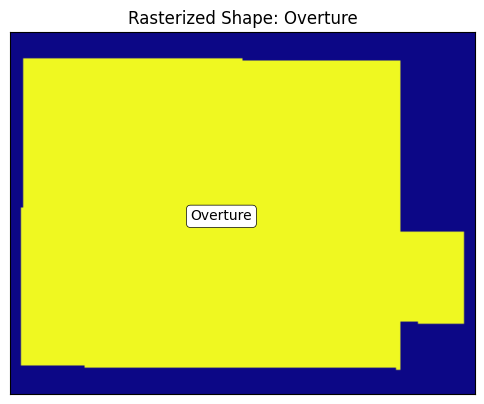

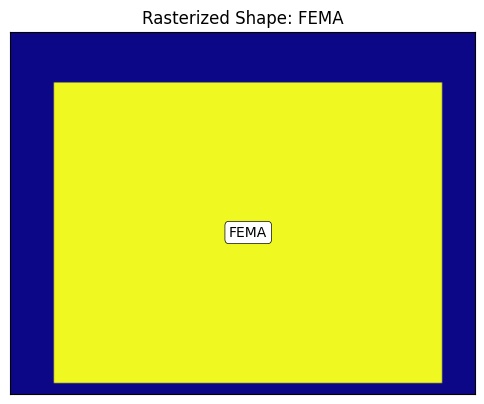

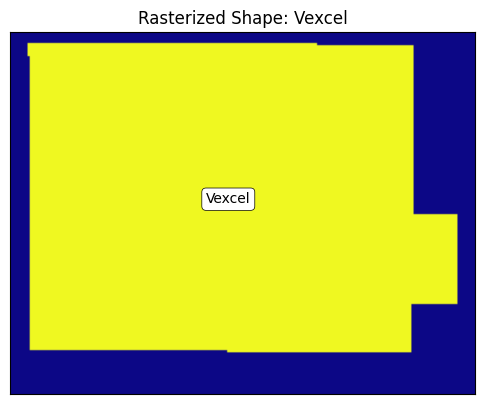

In [97]:
# --- Step 1: Load and reproject data ---
# Assuming you have already created the gdf with the structures
# If you haven't already, you can create it as shown before in first python cell

# --- Step 2: Reproject to UTM Zone 11N, makes it easy to adjust resolution in meters ---
gdf = gdf.to_crs(epsg=32611)

# --- Step 3: Compute bounding box ---
xmin, ymin, xmax, ymax = gdf.total_bounds

# --- Apply padding to bounding box ---
xmin -= 0.5  # Add padding to the left
ymin -= 0.5  # Add padding to the bottom   
xmax += 0.5  # Add padding to the right 
ymax += 0.5  # Add padding to the top

# --- Step 4: Define resolution in meters ---
resolution = 0.1  # 10 centimeters per pixel
nx = int((xmax - xmin) / resolution)
ny = int((ymax - ymin) / resolution)
print(f"Raster size: {nx} x {ny}")

# --- Step 5: Create an affine transform for rasterization ---
transform = Affine.translation(xmin, ymax) * Affine.scale(resolution, -resolution)

# --- Step 6: Loop through each shape and rasterize individually ---
for i, row in gdf.iterrows():
    shape = row.geometry
    name = row['name']

    # Create an empty raster for the current shape
    pa = np.zeros((ny, nx), dtype=np.uint8)

    # Rasterize only the current shape
    r = features.rasterize(
        [(mapping(shape), 1)],  # Assign pixel value 1 to this shape
        out_shape=(ny, nx),
        transform=transform
    )

    # Store rasterized shape in the raster array
    pa[r > 0] = 1  # Set rasterized pixels to 1 for visualization

    # --- Step 7: Plot the raster for the current shape ---
    plt.figure(figsize=(6, 6))

    # Plot the rasterized shape
    plt.imshow(pa, cmap='plasma', origin='upper', extent=[xmin, xmax, ymin, ymax])

    # Add the label at the centroid
    centroid = shape.centroid
    plt.text(
        centroid.x, centroid.y, f"{name}", fontsize=10, ha='center', va='center',
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5)
    )

    plt.title(f"Rasterized Shape: {name}")
    plt.xticks([])
    plt.yticks([])
    plt.show()

Raster size: 222 x 175


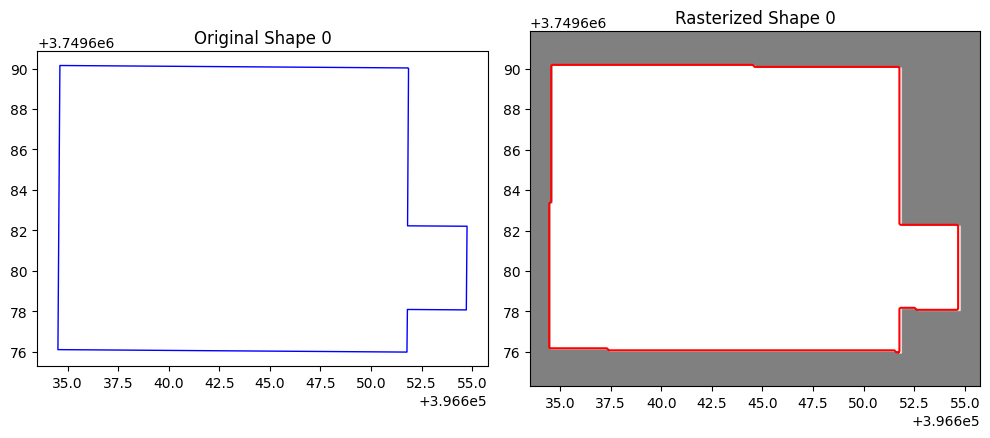

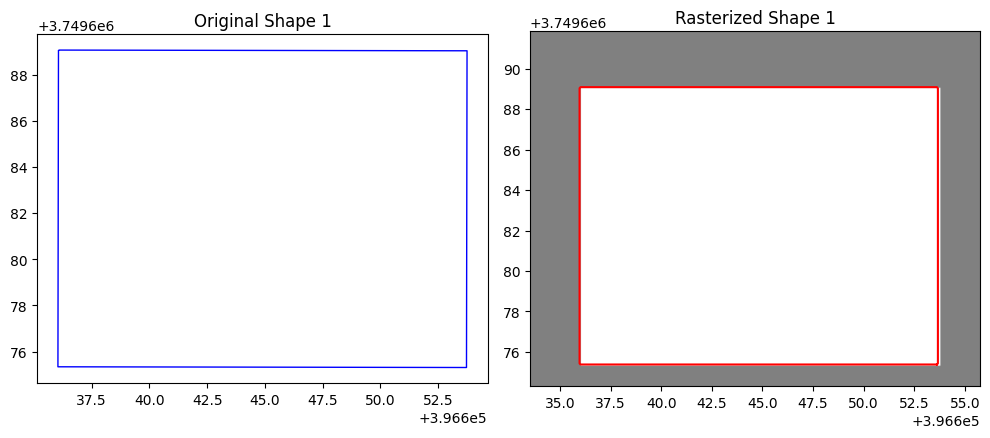

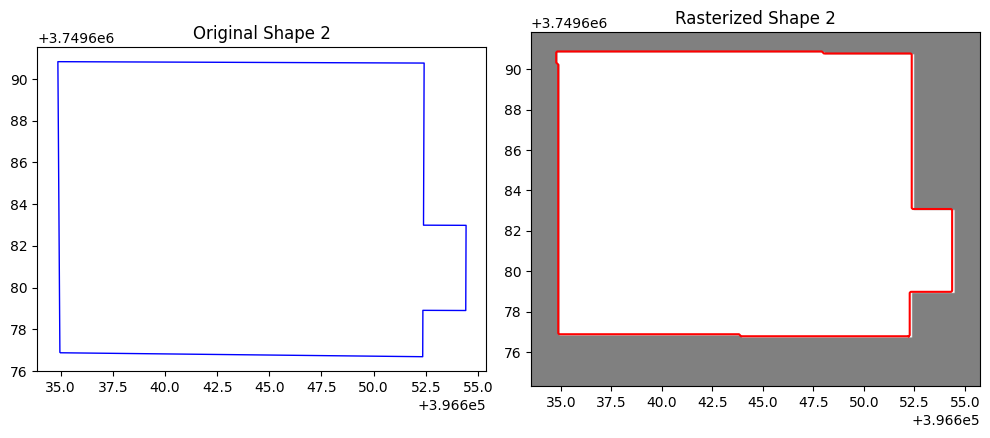

✅ Exported 3 rasterized polygons to 'rasterized_polygons.wkt'


d:\Program_Files\miniforge3\envs\playgound\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 'POLYGON ((-118.11755462498668 33.882374702106084, -118.11755570615455 33.882374692299486, -118.11755625261748 33.88237513826477, -118.1175567990804 33.88237558423005, -118.1175578802483 33.88237557442341, -118.11755896141618 33.88237556461679, -118.11756004258405 33.88237555481013, -118.11756112375193 33.88237554500348, -118.11756220491982 33.88237553519681, -118.1175632860877 33.88237552539014, -118.11756436725557 33.882375515583455, -118.11756544842345 33.882375505776764, -118.11756652959133 33.88237549597005, -118.11756761075922 33.88237548616335, -118.11756869192709 33.88237547635662, -118.11756977309497 33.882375466549895, -118.11757085426284 33.88237545674315, -118.11757193543072 33.8823754469364, -118.1175730165986 33.882375437129646, -118.11757409776646 33.88237542732288, -118.11757517893436 33.88237541751609, -118.11757626010221 33.882375407709304, -118.1175773412701 33.8823

In [ ]:
# Let's plot both the original and rasterized shapes side by side for comparison. 
# Include the polygon outline generated from the rasterized shape in raster window.

# --- Step 1: Load and reproject data ---
# Reproject to UTM Zone 11N (EPSG:32611)
gdf.to_crs(epsg=32611, inplace=True)

# Get bounding box for all shapes
xmin, ymin, xmax, ymax = gdf.total_bounds

# Get the centroid of the original geometry
centroid = shape.centroid
centroid_x, centroid_y = centroid.x, centroid.y

# --- Apply padding to bounding box ---
xmin -= 1.0  # Add padding to the left
ymin -= 1.0  # Add padding to the bottom   
xmax += 1.0  # Add padding to the right 
ymax += 1.0  # Add padding to the top

# --- Step 4: Define resolution in meters ---
resolution = 0.1  # 1 meter per pixel
nx = int((xmax - xmin) / resolution)
ny = int((ymax - ymin) / resolution)
print(f"Raster size: {nx} x {ny}")

# --- Step 5: Create an affine transform for rasterization ---
transform = Affine.translation(xmin, ymax) * Affine.scale(resolution, -resolution)


# Create an empty list to hold contour polygons
contour_polygons = []

# --- Step 6: Loop through each shape and rasterize individually ---
for i, row in gdf.iterrows():
    shape = row.geometry  # Get geometry directly from gdf
    name = row['name']    # Get name if needed

    # Create an empty raster for the current shape
    pa = np.zeros((ny, nx), dtype=np.uint8)

    # Rasterize only the current shape
    if shape.is_valid and not shape.is_empty:
        r = features.rasterize(
            [(mapping(shape), 1)],  # Assign pixel value 1 to this shape
            out_shape=(ny, nx),
            transform=transform, 
            all_touched=True  # Use all pixels touched by the polygon
        )

        # Store rasterized shape in the raster array
        pa[r > 0] = 1
    
    
    # --- Extract contours for the rasterized shape ---
    contours = find_contours(pa)  # Threshold 0.5 to capture shape boundaries
    
    # --- Convert each contour to a polygon ---
    for contour in contours:
        # Convert from (row, column) to (x, y) using the affine transformation
        #coords = [(transform * (x, y)) for y, x in contour]  # Fix row/column inversion
        coords = [(transform * (col, row)) for row, col in contour] 
        
        # Create the polygon from the contour
        polygon = Polygon(coords)

        
        # Ensure the polygon is valid and not empty
        if polygon.is_valid and not polygon.is_empty:
            # Add to list with attributes if needed
            contour_polygons.append({'geometry': polygon, 'name': name})

    # --- Plot original and rasterized shape side by side ---
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot original shape
    gdf.iloc[[i]].plot(ax=axes[0], color='none', edgecolor='blue')
    axes[0].set_title(f"Original Shape {i}")
    axes[0].set_aspect('equal')

    # Plot rasterized shape and contours
    extent = array_bounds(ny, nx, transform)  # Get correct extent
    axes[1].imshow(pa, cmap='gray', origin='upper', extent=[xmin, xmax, ymin, ymax], alpha=0.5)

    for polygon in contours:
        coords = [(transform * (x, y)) for y, x in polygon]
        p = Polygon(coords)
        if p.is_valid:
            x, y = p.exterior.xy
            axes[1].plot(x, y, color='red')

    axes[1].set_title(f"Rasterized Shape {i}")
    axes[1].set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

# --- Save WKT results to file ---
with open('rasterized_polygons.txt', 'w') as f:
    for wkt in wkt_list:
        f.write(wkt + '\n')

print(f"✅ Exported {len(wkt_list)} rasterized polygons to 'rasterized_polygons.wkt'")

# Create a GeoDataFrame with polygons
gdf_contours = gpd.GeoDataFrame(contour_polygons, crs="EPSG:32611")

# ✅ Reproject to EPSG:4326 (WGS84)
gdf_contours.to_crs(epsg=4326, inplace=True)

# Save WKT to file without manual transformation
gdf_contours['wkt'] = gdf_contours.geometry.apply(lambda geom: geom.wkt)

# Export to file
gdf_contours[['name','wkt']].to_csv('rasterized_polygons_10cm.csv', index=False, header=False)

#Save gdf to shapefile
gdf_contours.to_file('rasterized_polygons_10cm.shp')




Raster size: 222 x 175


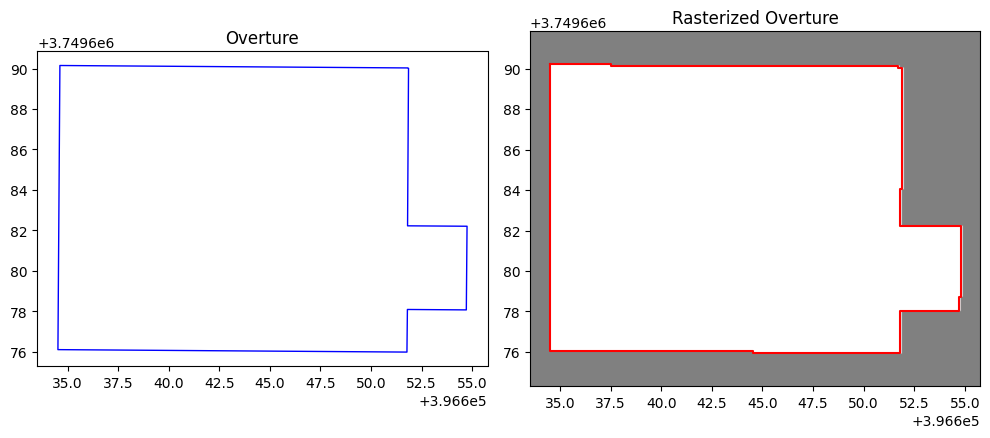

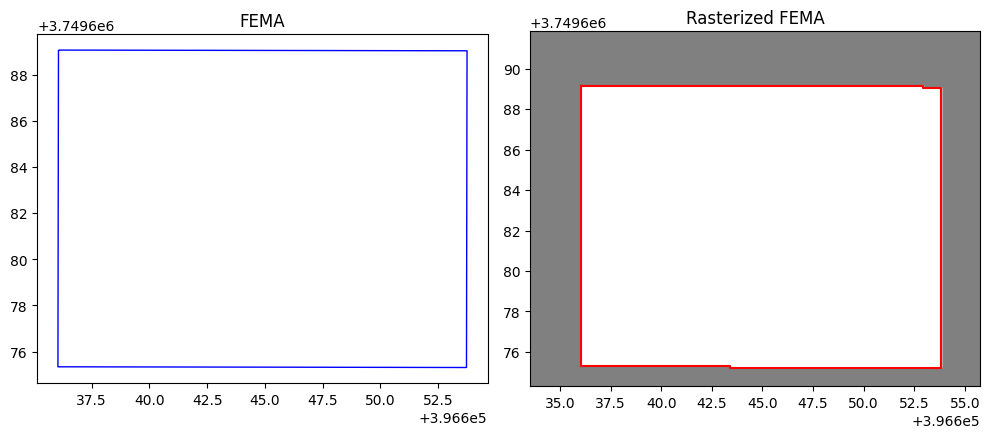

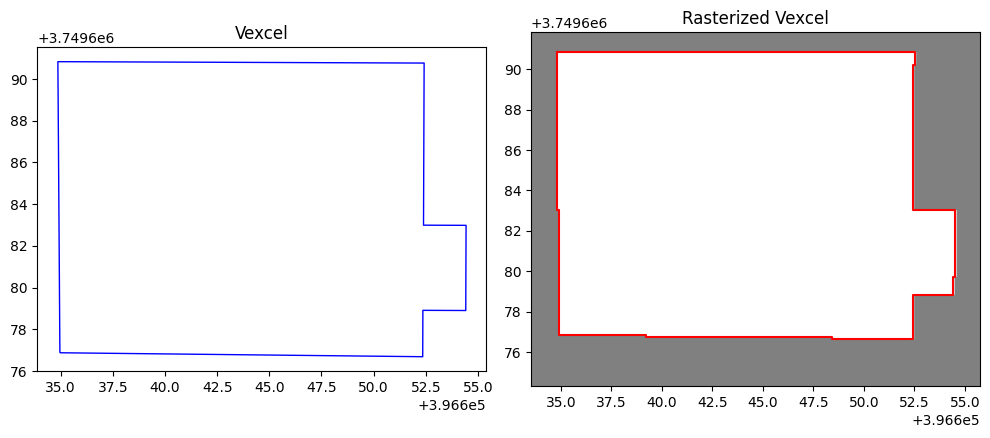

In [7]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, shape, mapping
from rasterio import features, Affine
from rasterio.transform import array_bounds

# --- Step 1: Load and reproject data ---
# Reproject to UTM Zone 11N (EPSG:32611)
gdf.to_crs(epsg=32611, inplace=True)

# Get bounding box for all shapes
xmin, ymin, xmax, ymax = gdf.total_bounds

# --- Apply padding to bounding box ---
xmin -= 1  # Add padding to the left
ymin -= 1  # Add padding to the bottom   
xmax += 1  # Add padding to the right 
ymax += 1  # Add padding to the top

# --- Step 4: Define resolution in meters ---
resolution = 0.1  # 10 cm per pixel
nx = int((xmax - xmin) / resolution)
ny = int((ymax - ymin) / resolution)
print(f"Raster size: {nx} x {ny}")

# --- Step 5: Create an affine transform for rasterization ---
transform = Affine.translation(xmin, ymax) * Affine.scale(resolution, -resolution)

# --- Step 6: Loop through each shape and rasterize individually ---
all_extracted_polygons = []  # Store all polygons here

for i, row in gdf.iterrows():
    geom = row.geometry  # Get geometry directly from gdf
    name = row['name']    # Get name if needed

    # Reset extracted_polygons for each iteration
    extracted_polygons = []  

    # Create an empty raster for the current shape
    pa = np.zeros((ny, nx), dtype=np.uint8)

    # Rasterize only the current shape
    if geom.is_valid and not geom.is_empty:
        r = features.rasterize(
            [(mapping(geom), 1)],  # Assign pixel value 1 to this shape
            out_shape=(ny, nx),
            transform=transform,
            fill=0,
            all_touched=True  # Ensure that all intersected pixels are filled
        )

        # Store rasterized shape in the raster array
        pa[r > 0] = 1

    # --- Extract shapes from the raster using rasterio.features.shapes() ---
    for polygon_geom, value in features.shapes(pa, transform=transform):
        if value == 1:  # Only keep pixels labeled as 1
            polygon = shape(polygon_geom)  # Convert to Shapely Polygon
            
            # Ensure the polygon is valid and not empty
            if polygon.is_valid and not polygon.is_empty:
                extracted_polygons.append({'geometry': polygon, 'name': name})

    # Store polygons from this iteration only
    all_extracted_polygons.extend(extracted_polygons)

    # --- Plot original and rasterized shape side by side ---
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot original shape
    gdf.iloc[[i]].plot(ax=axes[0], color='none', edgecolor='blue')
    axes[0].set_title(f"{name}")
    axes[0].set_aspect('equal')

    # Plot rasterized shape and extracted polygons
    extent = array_bounds(ny, nx, transform)  # Get correct extent
    axes[1].imshow(pa, cmap='gray', origin='upper', extent=[xmin, xmax, ymin, ymax], alpha=0.5)

    for poly in extracted_polygons:
        x, y = poly['geometry'].exterior.xy
        axes[1].plot(x, y, color='red')

    axes[1].set_title(f"Rasterized {name}")
    axes[1].set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

# --- Create and save GeoDataFrame ---
gdf_extracted = gpd.GeoDataFrame(all_extracted_polygons, crs="EPSG:32611")

# ✅ Reproject to EPSG:4326 (WGS84)
gdf_extracted.to_crs(epsg=4326, inplace=True)

# Save WKT and names
gdf_extracted.to_csv('rasterized_polygons_10cm.csv', index=False)
gdf_extracted.to_file('rasterized_polygons_10cm.shp')

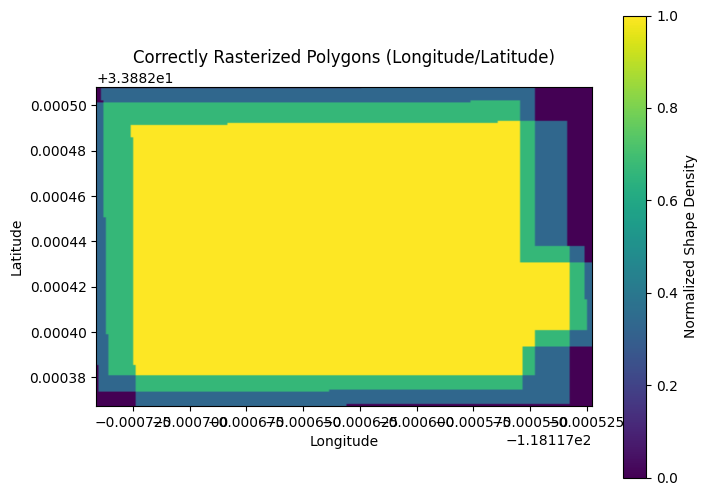

In [106]:
# Compute bounding box
xmin, ymin, xmax, ymax = (
    min(p.bounds[0] for p in structures), min(p.bounds[1] for p in structures),
    max(p.bounds[2] for p in structures), max(p.bounds[3] for p in structures)
)

# # Define raster resolution (degrees per pixel)
# nx, ny = 500, 500  # Higher resolution for better visualization
# xres = (xmax - xmin) / nx
# yres = (ymax - ymin) / ny

# Define degree-per-meter resolution at 33.88° latitude
lat_res = 0.0000009      # ~1 meter per pixel in latitude
lon_res = 0.00000109     # ~1 meter per pixel in longitude at 33.88° latitude

# Calculate raster dimensions
nx = int((xmax - xmin) / lon_res)
ny = int((ymax - ymin) / lat_res)

# Create affine transform for WGS 84 (still degrees, but 1-meter equivalent)
transform = Affine.translation(xmin, ymax) * Affine.scale(lon_res, -lat_res)
## Create an affine transform for the raster
#transform = Affine.translation(xmin, ymax) * Affine.scale(xres, -yres)

# Create an empty raster
pa = np.zeros((ny, nx), dtype=float)

# Rasterize each shape
for s in structures:
    r = features.rasterize([mapping(s)], out_shape=(ny, nx), transform=transform)
    pa[r > 0] += 1

# Normalize the raster
pa /= len(structures)

# Plot the raster
plt.figure(figsize=(8, 6))
plt.imshow(pa, cmap='viridis', origin='upper', extent=[xmin, xmax, ymin, ymax])
plt.colorbar(label="Normalized Shape Density")
plt.title("Correctly Rasterized Polygons (Longitude/Latitude)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Raster size: 222 x 175


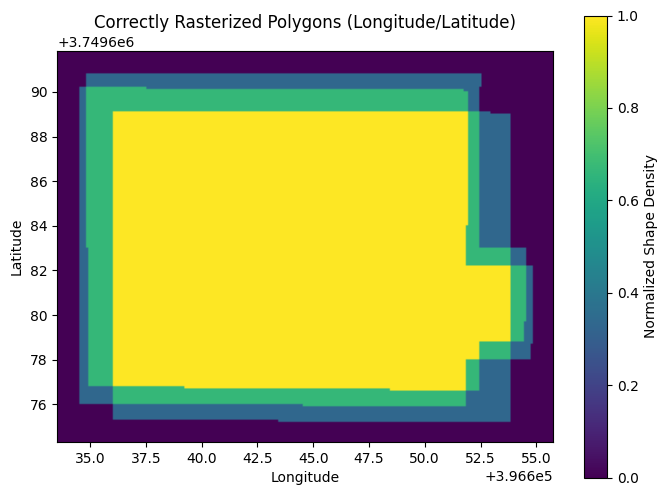

In [122]:
# --- Step 1: Load and reproject data ---
# Reproject to UTM Zone 11N (EPSG:32611)
gdf.to_crs(epsg=32611, inplace=True)

# Get bounding box for all shapes
xmin, ymin, xmax, ymax = gdf.total_bounds

# --- Apply padding to bounding box ---
xmin -= 1.0  # Add padding to the left
ymin -= 1.0  # Add padding to the bottom   
xmax += 1.0  # Add padding to the right 
ymax += 1.0  # Add padding to the top

# --- Step 4: Define resolution in meters ---
resolution = 0.1  # 10 cm per pixel
nx = int((xmax - xmin) / resolution)
ny = int((ymax - ymin) / resolution)
print(f"Raster size: {nx} x {ny}")

# --- Step 5: Create an affine transform for rasterization ---
transform = Affine.translation(xmin, ymax) * Affine.scale(resolution, -resolution)

# Create an empty raster for ALL shapes
pa = np.zeros((ny, nx), dtype=float)

# Rasterize each shape and accumulate
for i, row in gdf.iterrows():
    geom = row.geometry

    if geom.is_valid and not geom.is_empty:
        r = features.rasterize(
            [(mapping(geom), 1)],  # Assign value 1 to this shape
            out_shape=(ny, nx),
            transform=transform,
            fill=0,
            all_touched=True
        )

        # Accumulate the number of times a pixel is covered
        pa += r  

# Normalize by the max value per pixel
pa /= len(gdf)  # Each pixel gets divided by the number of total shapes


# Plot the raster
plt.figure(figsize=(8, 6))
plt.imshow(pa, cmap='viridis', origin='upper', extent=[xmin, xmax, ymin, ymax])
plt.colorbar(label="Normalized Shape Density")
plt.title("Correctly Rasterized Polygons (Longitude/Latitude)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Step 1: Threshold the raster (set values >= 0.8 to 1, others to 0)
threshold = 0.8
binary_mask = (pa >= threshold).astype(np.uint8)

# Step 2: Extract shapes from the raster
transform = Affine.translation(xmin, ymax) * Affine.scale(resolution, -resolution)

shapes = list(features.shapes(binary_mask, transform=transform))

# Step 3: Convert to GeoDataFrame
geometries = [shape(geom) for geom, value in shapes if value == 1]
gdf_filtered = gpd.GeoDataFrame(geometry=geometries, crs="EPSG:32611")  # Use your projected CRS

# Step 4: Export to Shapefile
gdf_filtered.to_file("filtered_areas.shp")


Raster size: 222 x 175


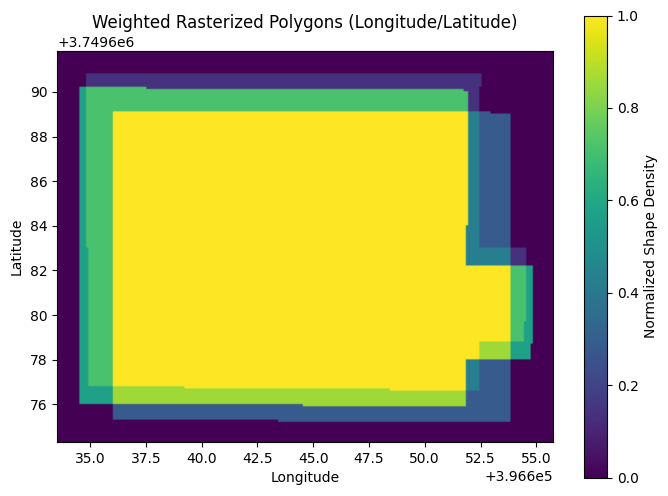

In [ ]:
#Let's apply a weighted approach
# --- Step 1: Load and reproject data ---


# Reproject to UTM Zone 11N (EPSG:32611)
gdf.to_crs(epsg=32611, inplace=True)

# Get bounding box for all shapes
xmin, ymin, xmax, ymax = gdf.total_bounds

# --- Apply padding to bounding box ---
xmin -= 1.0  # Add padding to the left
ymin -= 1.0  # Add padding to the bottom   
xmax += 1.0  # Add padding to the right 
ymax += 1.0  # Add padding to the top

# --- Step 4: Define resolution in meters ---
resolution = 0.1  # 10 cm per pixel
nx = int((xmax - xmin) / resolution)
ny = int((ymax - ymin) / resolution)
print(f"Raster size: {nx} x {ny}")

# --- Step 5: Create an affine transform for rasterization ---
transform = Affine.translation(xmin, ymax) * Affine.scale(resolution, -resolution)

# Create an empty raster for ALL shapes
pa = np.zeros((ny, nx), dtype=float)

# Rasterize each shape and accumulate
for i, row in gdf.iterrows():
    geom = row.geometry
    weight = row.get('weight', 1)  # Default to 1 if weight column is missing

    if geom.is_valid and not geom.is_empty:
        r = features.rasterize(
            [(mapping(geom), weight)],  # Assign the weight instead of 1
            out_shape=(ny, nx),
            transform=transform,
            fill=0,
            all_touched=True
        )

        # Accumulate the number of times a pixel is covered
        pa += r  

# Normalize by the max value per pixel
pa /= pa.max()  # Normalize based on max accumulated value



# Plot the raster
plt.figure(figsize=(8, 6))
plt.imshow(pa, cmap='viridis', origin='upper', extent=[xmin, xmax, ymin, ymax])
plt.colorbar(label="Normalized Shape Density")
plt.title("Weighted Rasterized Polygons (Longitude/Latitude)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Step 1: Threshold the raster (set values >= 0.8 to 1, others to 0)
threshold = 0.4
binary_mask = (pa >= threshold).astype(np.uint8)

# Step 2: Extract shapes from the raster
transform = Affine.translation(xmin, ymax) * Affine.scale(resolution, -resolution)

shapes = list(features.shapes(binary_mask, transform=transform))

# Step 3: Convert to GeoDataFrame
geometries = [shape(geom) for geom, value in shapes if value == 1]
gdf_filtered = gpd.GeoDataFrame(geometry=geometries, crs="EPSG:32611")  # Use your projected CRS

# Apply smoothing
#gdf_filtered["geometry"] = gdf_filtered["geometry"].buffer(0.5).buffer(-0.5)  # Buffer-based smoothing
gdf_filtered["geometry"] = gdf_filtered["geometry"].simplify(0.2)  # Simplify edges

# Step 4: Export to Shapefile
gdf_filtered.to_file("filtered_areas_weighted_4new_smooth.shp")


In [ ]:
#Let's apply a weighted approach using samepl data from shapefile
# --- Step 1: Load and reproject data ---
# Create gdf from shapefile
structures_merged = gpd.read_file(r'D:\Documents\GitHub\master_structure_poc\samples\merged.shp')


# Reproject to UTM Zone 11N (EPSG:32611)
gdf.to_crs(epsg=32611, inplace=True)

# Get bounding box for all shapes
xmin, ymin, xmax, ymax = gdf.total_bounds

# --- Apply padding to bounding box ---
xmin -= 1.0  # Add padding to the left
ymin -= 1.0  # Add padding to the bottom   
xmax += 1.0  # Add padding to the right 
ymax += 1.0  # Add padding to the top

# --- Step 4: Define resolution in meters ---
resolution = 0.1  # 10 cm per pixel
nx = int((xmax - xmin) / resolution)
ny = int((ymax - ymin) / resolution)
print(f"Raster size: {nx} x {ny}")

# --- Step 5: Create an affine transform for rasterization ---
transform = Affine.translation(xmin, ymax) * Affine.scale(resolution, -resolution)

# Create an empty raster for ALL shapes
pa = np.zeros((ny, nx), dtype=float)

# Rasterize each shape and accumulate
for i, row in gdf.iterrows():
    geom = row.geometry
    weight = row.get('weight', 1)  # Default to 1 if weight column is missing

    if geom.is_valid and not geom.is_empty:
        r = features.rasterize(
            [(mapping(geom), weight)],  # Assign the weight instead of 1
            out_shape=(ny, nx),
            transform=transform,
            fill=0,
            all_touched=True
        )

        # Accumulate the number of times a pixel is covered
        pa += r  

# Normalize by the max value per pixel
pa /= pa.max()  # Normalize based on max accumulated value



# Plot the raster
plt.figure(figsize=(8, 6))
plt.imshow(pa, cmap='viridis', origin='upper', extent=[xmin, xmax, ymin, ymax])
plt.colorbar(label="Normalized Shape Density")
plt.title("Weighted Rasterized Polygons (Longitude/Latitude)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Step 1: Threshold the raster (set values >= 0.8 to 1, others to 0)
threshold = 0.4
binary_mask = (pa >= threshold).astype(np.uint8)

# Step 2: Extract shapes from the raster
transform = Affine.translation(xmin, ymax) * Affine.scale(resolution, -resolution)

shapes = list(features.shapes(binary_mask, transform=transform))

# Step 3: Convert to GeoDataFrame
geometries = [shape(geom) for geom, value in shapes if value == 1]
gdf_filtered = gpd.GeoDataFrame(geometry=geometries, crs="EPSG:32611")  # Use your projected CRS

# Apply smoothing
#gdf_filtered["geometry"] = gdf_filtered["geometry"].buffer(0.5).buffer(-0.5)  # Buffer-based smoothing
gdf_filtered["geometry"] = gdf_filtered["geometry"].simplify(0.2)  # Simplify edges

# Step 4: Export to Shapefile
gdf_filtered.to_file("filtered_areas_weighted_4new_smooth.shp")


      source                                           geometry
0   overture  POLYGON ((-118.11755 33.8825, -118.11755 33.88...
1   overture  POLYGON ((-118.13201 33.89027, -118.132 33.890...
2   overture  POLYGON ((-118.13225 33.88978, -118.13225 33.8...
3   overture  POLYGON ((-118.13155 33.88987, -118.13155 33.8...
4     vexcel  POLYGON ((-118.11774 33.88238, -118.11774 33.8...
5     vexcel  POLYGON ((-118.13232 33.88983, -118.13232 33.8...
6     vexcel  POLYGON ((-118.13201 33.89018, -118.13199 33.8...
7     vexcel  POLYGON ((-118.13168 33.88946, -118.13168 33.8...
8       fema  POLYGON ((-118.13154 33.88987, -118.13153 33.8...
9       fema  POLYGON ((-118.132 33.89027, -118.13188 33.890...
10      fema  POLYGON ((-118.11773 33.88249, -118.11753 33.8...
11      fema  POLYGON ((-118.13218 33.88982, -118.13209 33.8...
      source                                           geometry  weight
0   overture  POLYGON ((-118.11755 33.8825, -118.11755 33.88...     5.0
1   overture  POLYGON ((

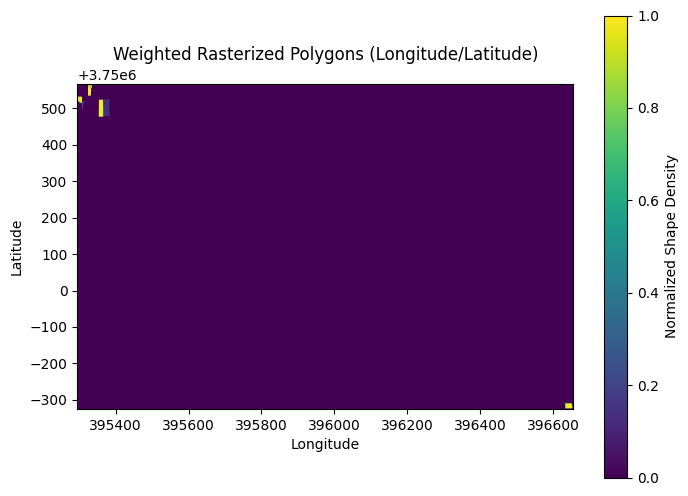

In [16]:
# Create gdf from shapefile
structures_merged = gpd.read_file(r'D:\Documents\GitHub\master_structure_poc\samples\merged.shp')

print(structures_merged)

# Define weights for each source
weight_mapping = {
    'overture': 5.0,
    'vexcel': 1.0,
    'fema': 1.5
}

# Add a weight column based on the source
structures_merged["weight"] = structures_merged["source"].map(weight_mapping)

print(structures_merged)

# Reproject to UTM Zone 11N (EPSG:32611)
structures_merged.to_crs(epsg=32611, inplace=True)

# Get bounding box for all shapes
xmin, ymin, xmax, ymax = structures_merged.total_bounds

# --- Apply padding to bounding box ---
xmin -= 1.0  # Add padding to the left
ymin -= 1.0  # Add padding to the bottom   
xmax += 1.0  # Add padding to the right 
ymax += 1.0  # Add padding to the top

# --- Step 4: Define resolution in meters ---
resolution = 0.1  # 10 cm per pixel
nx = int((xmax - xmin) / resolution)
ny = int((ymax - ymin) / resolution)
print(f"Raster size: {nx} x {ny}")

# --- Step 5: Create an affine transform for rasterization ---
transform = Affine.translation(xmin, ymax) * Affine.scale(resolution, -resolution)

# Create an empty raster for ALL shapes
pa = np.zeros((ny, nx), dtype=float)

# Rasterize each shape and accumulate
for i, row in structures_merged.iterrows():
    geom = row.geometry
    weight = row.get('weight', 1)  # Default to 1 if weight column is missing

    if geom.is_valid and not geom.is_empty:
        r = features.rasterize(
            [(mapping(geom), weight)],  # Assign the weight instead of 1
            out_shape=(ny, nx),
            transform=transform,
            fill=0,
            all_touched=True
        )

        # Accumulate the number of times a pixel is covered
        pa += r  

# Normalize by the max value per pixel
pa /= pa.max()  # Normalize based on max accumulated value



# Plot the raster
plt.figure(figsize=(8, 6))
plt.imshow(pa, cmap='viridis', origin='upper', extent=[xmin, xmax, ymin, ymax])
plt.colorbar(label="Normalized Shape Density")
plt.title("Weighted Rasterized Polygons (Longitude/Latitude)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Step 1: Threshold the raster (set values >= 0.8 to 1, others to 0)
threshold = 1
binary_mask = (pa >= threshold).astype(np.uint8)

# Step 2: Extract shapes from the raster
transform = Affine.translation(xmin, ymax) * Affine.scale(resolution, -resolution)

shapes = list(features.shapes(binary_mask, transform=transform))

# Step 3: Convert to GeoDataFrame
geometries = [shape(geom) for geom, value in shapes if value == 1]
gdf_filtered = gpd.GeoDataFrame(geometry=geometries, crs="EPSG:32611")  # Use your projected CRS

# Apply smoothing
#gdf_filtered["geometry"] = gdf_filtered["geometry"].buffer(0.5).buffer(-0.5)  # Buffer-based smoothing
gdf_filtered["geometry"] = gdf_filtered["geometry"].simplify(0.2)  # Simplify edges

# Step 4: Export to Shapefile
gdf_filtered.to_file(f"merged_threshold2_1.shp")



In [20]:
# Step 1: Threshold the raster (set values >= 0.8 to 1, others to 0)
threshold = 0.4
binary_mask = (pa >= threshold).astype(np.uint8)

# Step 2: Extract shapes from the raster
transform = Affine.translation(xmin, ymax) * Affine.scale(resolution, -resolution)

shapes = list(features.shapes(binary_mask, transform=transform))

# Step 3: Convert to GeoDataFrame
geometries = [shape(geom) for geom, value in shapes if value == 1]
gdf_filtered = gpd.GeoDataFrame(geometry=geometries, crs="EPSG:32611")  # Use your projected CRS

# Apply smoothing
#gdf_filtered["geometry"] = gdf_filtered["geometry"].buffer(0.5).buffer(-0.5)  # Buffer-based smoothing
gdf_filtered["geometry"] = gdf_filtered["geometry"].simplify(0.2)  # Simplify edges

# Step 4: Export to Shapefile
gdf_filtered.to_file(f"merged_threshold2_4.shp")